In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
PIPS_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/2019'
parsivel_combined_filename = 'parsivel_combined_TriPIPS_092719_TriPIPS_10s.nc'
parsivel_combined_path = os.path.join(PIPS_dir, parsivel_combined_filename)
parsivel_combined_ds = xr.open_dataset(parsivel_combined_path)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() 

In [4]:
print(parsivel_combined_ds)

<xarray.Dataset>
Dimensions:            (diameter_bin: 32, fallspeed_bin: 32, fields: 12, fields_KIND: 9, fields_xtrra: 12, parameter: 3, time: 8640)
Coordinates:
    diameter           (diameter_bin) float64 ...
    fallspeed          (fallspeed_bin) float64 ...
  * fields             (fields) object 'reflectivity' ... 'cross_correlation_...
    max_diameter       (diameter_bin) float64 ...
    max_fallspeeds     (fallspeed_bin) float64 ...
    min_diameter       (diameter_bin) float64 ...
    min_fallspeeds     (fallspeed_bin) float64 ...
  * parameter          (parameter) object 'N0' 'lamda' 'alpha'
  * time               (time) datetime64[ns] 2019-09-27T00:00:10 ... 2019-09-28
  * fields_KIND        (fields_KIND) object 'REF_s3' 'VEL' ... 'REF' 'PHI'
  * fields_xtrra       (fields_xtrra) object 'corrected_differential_reflecti...
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    DSD_MM234          (parameter, time) float64 ...
    DSD_MM24           (p

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
radar_at_PIPS_da = parsivel_combined_ds['xtrra_at_PIPS']
print(radar_at_PIPS_da)
#print(radar_at_PIPS_da.coords['fields'].values)
fields = radar_at_PIPS_da.coords['fields_xtrra'].values
field_name = next((fname for fname in fields if fname in radar.REF_aliases))
print(field_name)

<xarray.DataArray 'xtrra_at_PIPS' (time: 8640, fields_xtrra: 12)>
[103680 values with dtype=float64]
Coordinates:
  * time          (time) datetime64[ns] 2019-09-27T00:00:10 ... 2019-09-28
  * fields_xtrra  (fields_xtrra) object 'corrected_differential_reflectivity'...
Attributes:
    radar_name:   xtrra
    PIPS_name:    TriPIPS
    PIPS_x:       -6721.960677586845
    PIPS_y:       4978.994771696108
    beam_height:  750.5521569997072
corrected_reflectivity


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from natsort import natsorted
radar_name = 'XTRRA'
radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial'
radar_paths = glob.glob(radar_dir + '/xtrra_20190927-[1-2][9,0]*.nc')
radar_paths = natsorted(radar_paths)
print(radar_paths)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190015.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190033.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190052.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190110.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190129.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190147.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190206.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190224.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190246.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRad

In [8]:
sweeptime_start = radar._getsweeptime(radar_paths[0])
sweeptime_stop = radar._getsweeptime(radar_paths[-1])
print(sweeptime_start, sweeptime_stop)

radar_paths2 = []
sweeptimes2 = []
el_req = 2.4
for radar_path in radar_paths:
    elevation = radar._getelev(radar_path)
    sweeptime = radar._getsweeptime(radar_path)
    if np.abs(elevation - el_req) < 0.1:
        print(elevation)
        print(os.path.basename(radar_path))
        radar_paths2.append(radar_path)
        sweeptimes2.append(sweeptime)
        

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING

2019-09-27 19:00:15 2019-09-27 20:59:52


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-190429.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-190939.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-191449.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-191958.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-192508.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-193017.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-193527.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-194037.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-194546.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-195056.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-195606.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-200115.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-200625.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-201135.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-201644.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-202154.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-202703.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-203213.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-203723.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-204232.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-204742.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-205252.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-205801.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

In [9]:
starttime = '20190927190015'
stoptime = '20190927205801'

radar_dict = radar.read_sweeps(radar_paths2, starttime, stoptime)
print(radar_dict['radarsweeplist'])

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190429.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.39064
Time of sweep =  2019-09-27 19:04:29 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190939.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3984680000000003
Time of sweep =  2019-09-27 19:09:39 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-191449.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3878589999999997
Time of sweep =  2019-09-27 19:14:49 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-191958.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394847
Time of sweep =  2019-09-27 19:19:58 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-192508.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3917215
Time of sweep =  2019-09-27 19:25:08 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-193017.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:179: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mode = netCDF4.chartostring(sweep_mode['data'][0])[()].decode('utf-8')
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:182: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mode = netCDF4.chartostring(sweep_mode['data'][0])[()]
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: Deprecation

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3927365
Time of sweep =  2019-09-27 19:30:17 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-193527.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3939865
Time of sweep =  2019-09-27 19:35:27 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-194037.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3981525
Time of sweep =  2019-09-27 19:40:37 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-194546.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3953835
Time of sweep =  2019-09-27 19:45:46 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-195056.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3927365
Time of sweep =  2019-09-27 19:50:56 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-195606.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.389095
Time of sweep =  2019-09-27 19:56:06 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-200115.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.395641
Time of sweep =  2019-09-27 20:01:15 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-200625.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3886905
Time of sweep =  2019-09-27 20:06:25 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-201135.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3898824999999997
Time of sweep =  2019-09-27 20:11:35 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-201644.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394847
Time of sweep =  2019-09-27 20:16:44 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-202154.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3894925000000002
Time of sweep =  2019-09-27 20:21:54 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-202703.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3882785
Time of sweep =  2019-09-27 20:27:03 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-203213.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394281
Time of sweep =  2019-09-27 20:32:13 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-203723.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.389095
Time of sweep =  2019-09-27 20:37:23 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-204232.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3933765
Time of sweep =  2019-09-27 20:42:32 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-204742.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3965959999999997
Time of sweep =  2019-09-27 20:47:42 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205252.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3910080000000002
Time of sweep =  2019-09-27 20:52:52 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205801.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3924054999999997
Time of sweep =  2019-09-27 20:58:01 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
[<pyart.core.radar.Radar object at 0x7fac41763640>, <pyart.core.radar.Radar object at 0x7fac41763b80>, <pyart.core.radar.Radar object at 0x7fac81418ee0>, <pyart.core.radar.Radar object at 0x7fac81418940>, <pyart.core.radar.Radar object at 0x7fac41763af0>, <pyart.core.radar.Radar object at 0x7fac81434d00>, <pyart.core.radar.Radar object at 0x7fac41763f40>, <pyart.core.radar.Radar object at 0x7fac8144cbe0>, <pyart.core.radar.Radar object at 0x7fac8144c880>, <pyart.core.radar.Radar object at 0x7fac41937c70>, <pyart.core.radar.Radar object at 0x7fac41937730>, <pyart.core.radar.Radar object at 0x7fac81434d90>, <pyart.core.radar.Radar object at 0x7fac81418460>, <pyart.core.radar.Radar object a

In [17]:
# GPS_stats = conv_df['GPS_status']
# GPS_lats = conv_df['GPS_lat']
# GPS_lons = conv_df['GPS_lon']
# GPS_alts = conv_df['GPS_alt']
# PIPS_lat, PIPS_lon, PIPS_alt = pipsio.get_PIPS_loc(GPS_stats, GPS_lats, GPS_lons, GPS_alts)
PIPS_loc_str = parsivel_combined_ds.location
rlat = radar_dict['radarsweeplist'][0].latitude['data'][0]
rlon = radar_dict['radarsweeplist'][0].longitude['data'][0]
ralt = radar_dict['radarsweeplist'][0].altitude['data'][0]

PIPS_lat, PIPS_lon, PIPS_alt = list(map(np.float, PIPS_loc_str.strip('()').split(',')))
PIPS_rad_loc = radar.get_PIPS_loc_relative_to_radar((PIPS_lat, PIPS_lon, PIPS_alt), rlat, rlon, ralt)
print(PIPS_rad_loc)

Radar location (lat, lon, alt) 40.43014 -86.91218 212.0
Disdrometer location (lat, lon, alt) 40.47489 -86.99165 214.0
PIPS location relative to radar (x, y, z) -6721.960677586845 4978.994771696108 2.0
(-6721.960677586845, 4978.994771696108, 2.0)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


495 142
Time:  2019-09-27 19:04:29
Elevation:  2.4


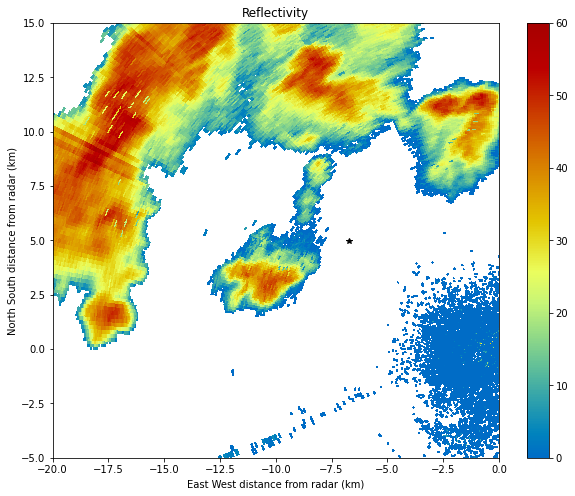

495 142
Time:  2019-09-27 19:09:39
Elevation:  2.4


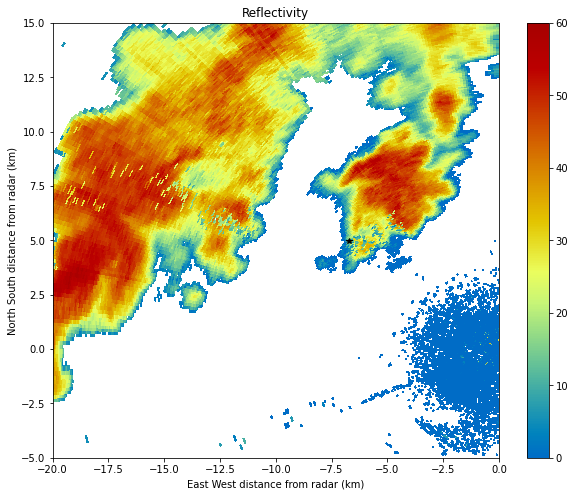

496 142
Time:  2019-09-27 19:14:49
Elevation:  2.4


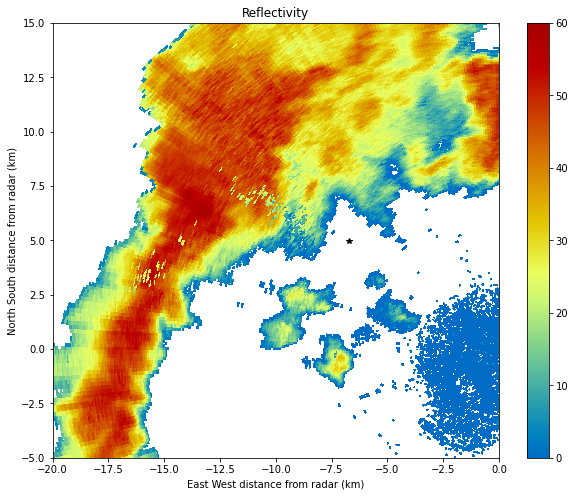

495 142
Time:  2019-09-27 19:19:58
Elevation:  2.4


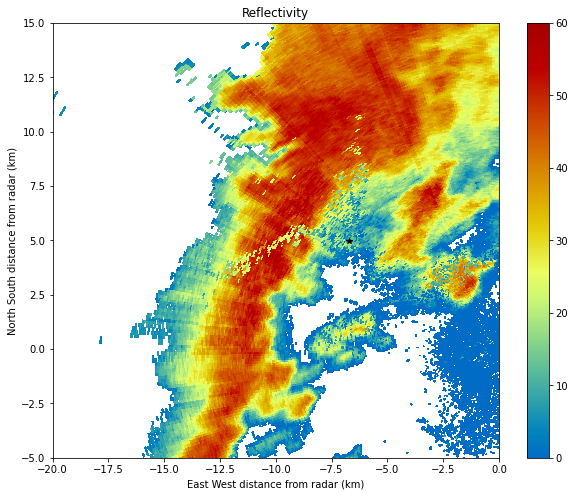

495 142
Time:  2019-09-27 19:25:08
Elevation:  2.4


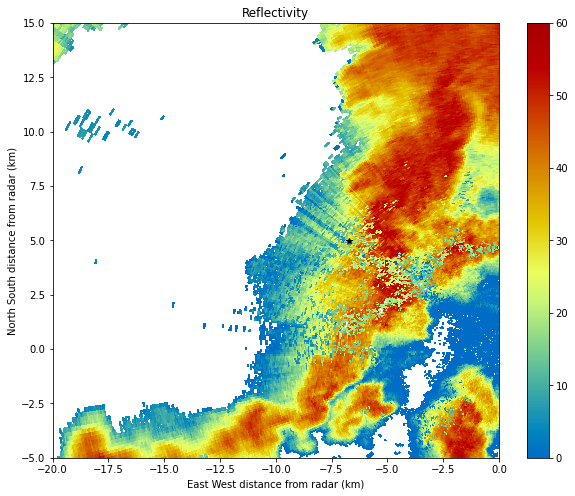

495 142
Time:  2019-09-27 19:30:17
Elevation:  2.4


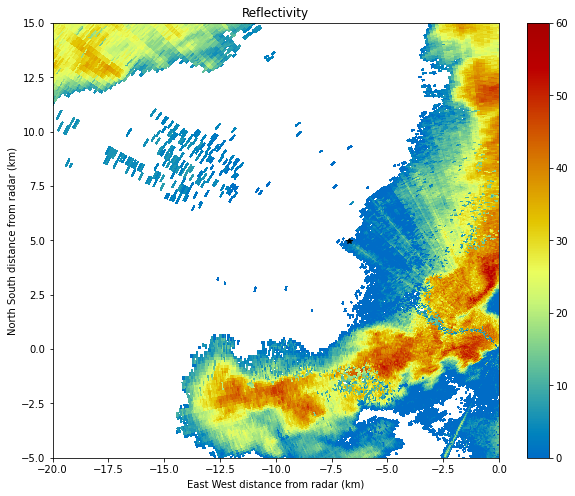

495 142
Time:  2019-09-27 19:35:27
Elevation:  2.4


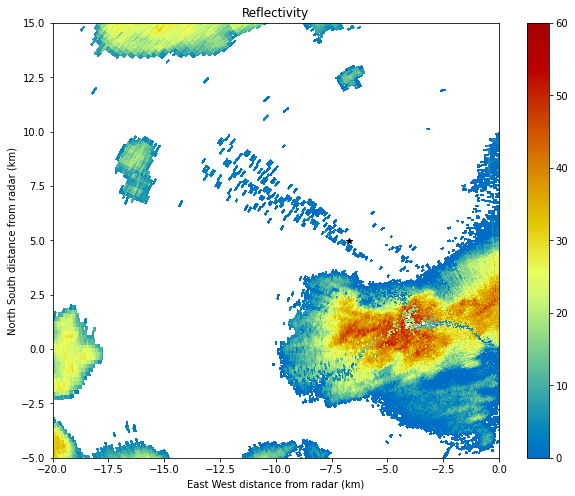

495 142
Time:  2019-09-27 19:40:37
Elevation:  2.4


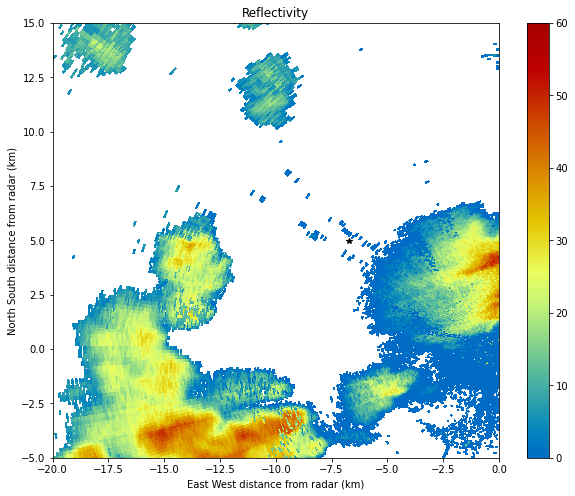

495 142
Time:  2019-09-27 19:45:46
Elevation:  2.4


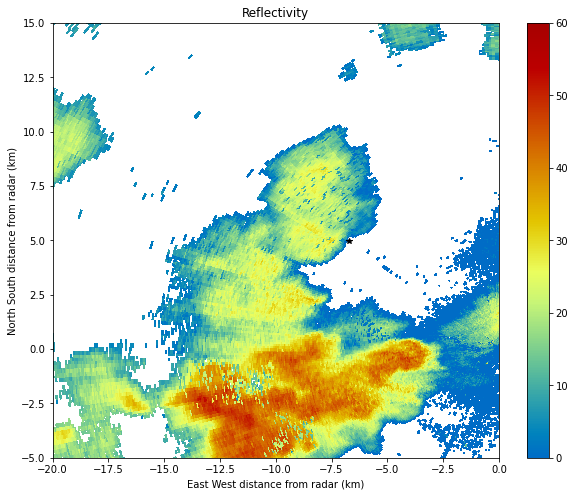

495 142
Time:  2019-09-27 19:50:56
Elevation:  2.4


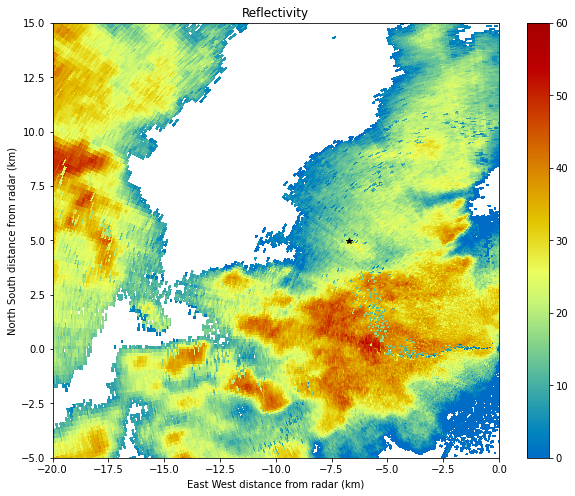

495 142
Time:  2019-09-27 19:56:06
Elevation:  2.4


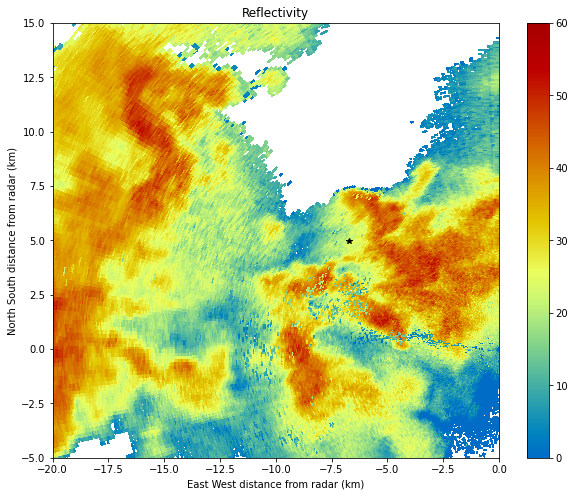

495 142
Time:  2019-09-27 20:01:15
Elevation:  2.4


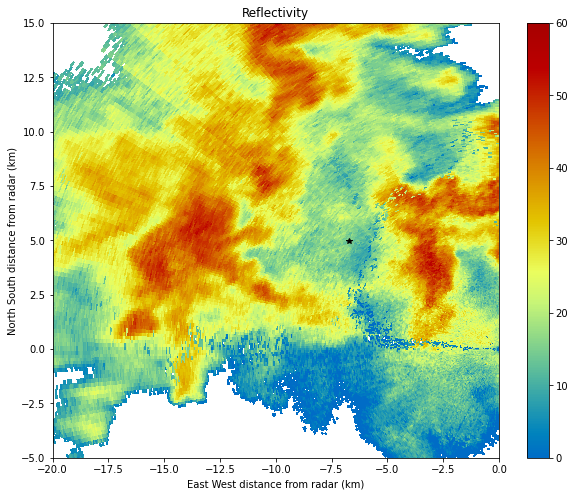

495 142
Time:  2019-09-27 20:06:25
Elevation:  2.4


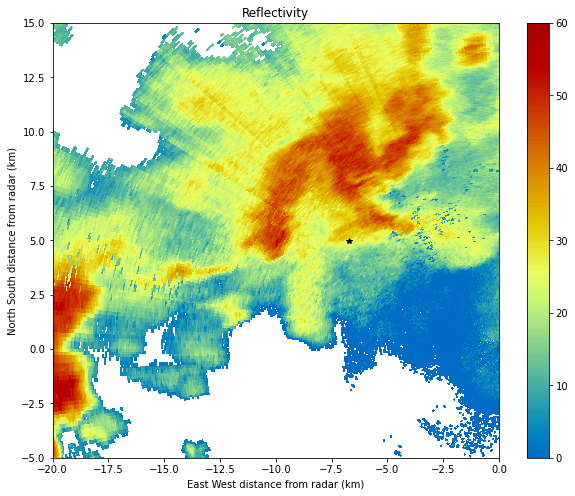

495 142
Time:  2019-09-27 20:11:35
Elevation:  2.4


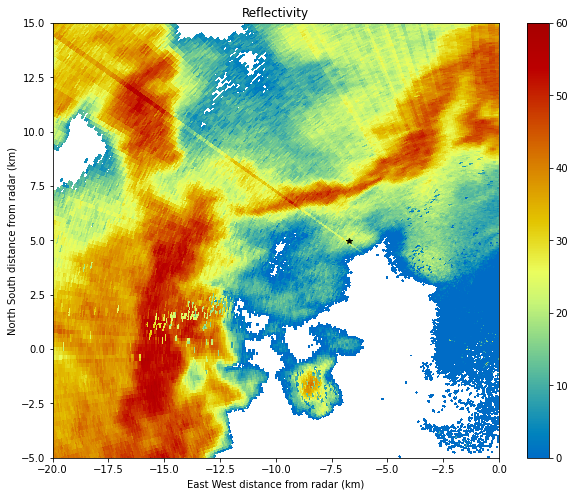

495 142
Time:  2019-09-27 20:16:44
Elevation:  2.4


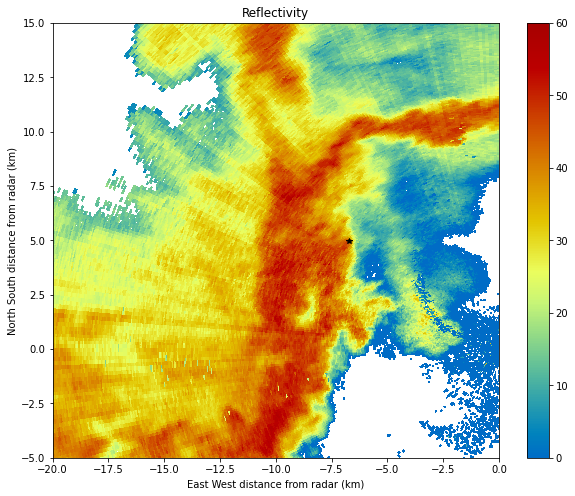

495 142
Time:  2019-09-27 20:21:54
Elevation:  2.4


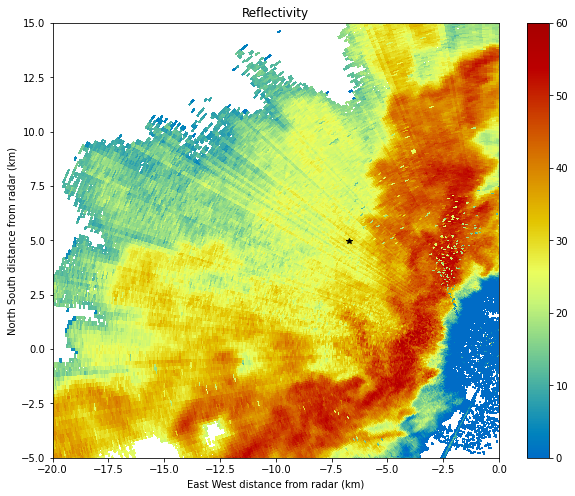

496 142
Time:  2019-09-27 20:27:03
Elevation:  2.4


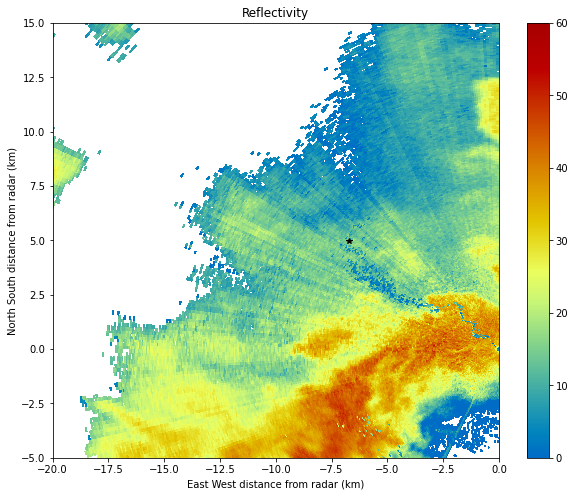

495 142
Time:  2019-09-27 20:32:13
Elevation:  2.4


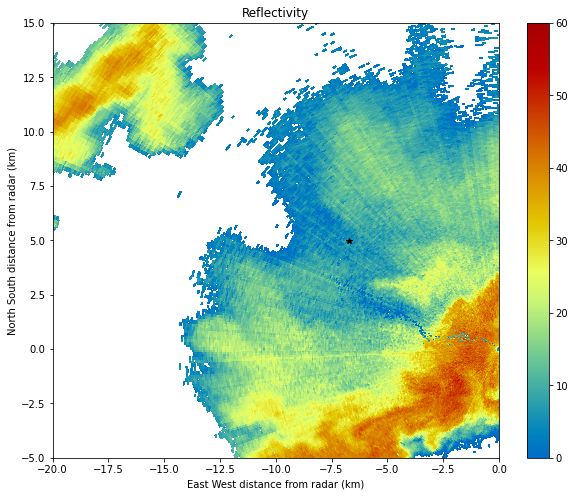

496 142
Time:  2019-09-27 20:37:23
Elevation:  2.4


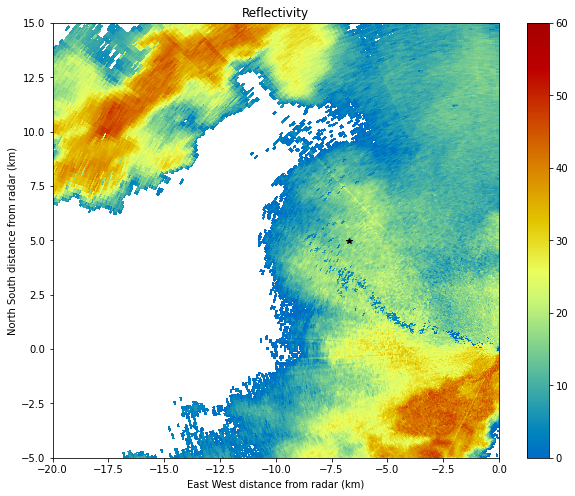

495 142
Time:  2019-09-27 20:42:32
Elevation:  2.4


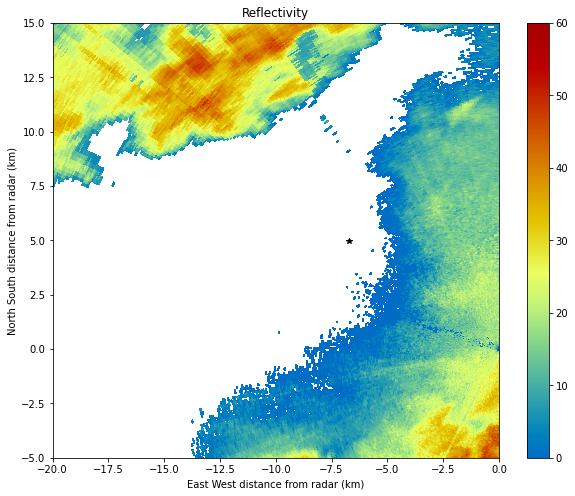

494 142
Time:  2019-09-27 20:47:42
Elevation:  2.4


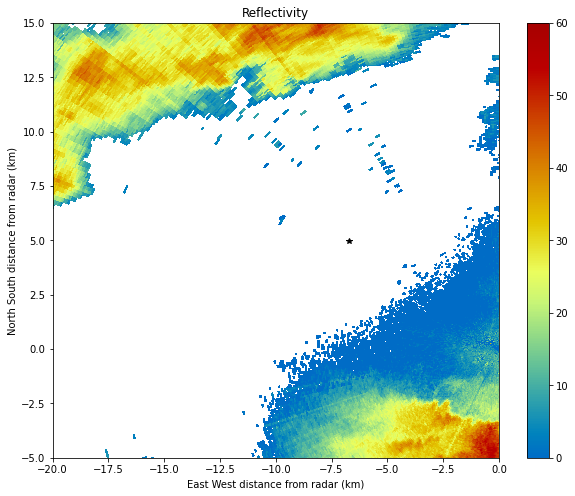

495 142
Time:  2019-09-27 20:52:52
Elevation:  2.4


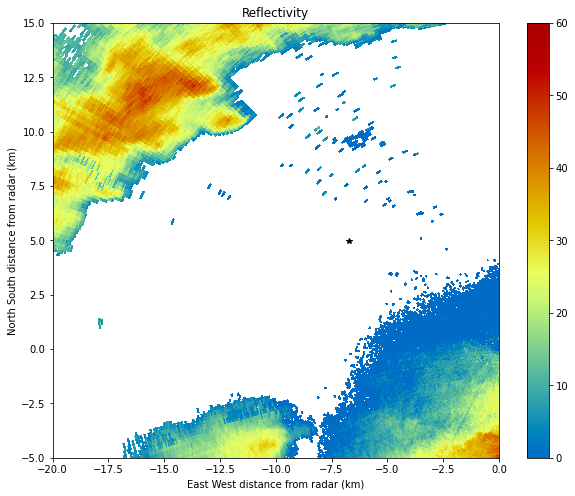

495 142
Time:  2019-09-27 20:58:01
Elevation:  2.4


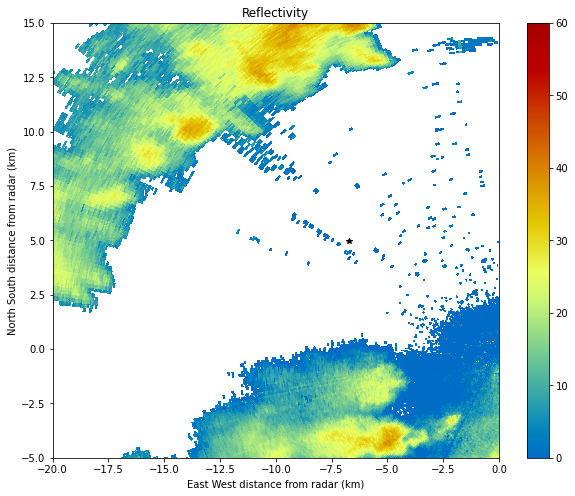

In [18]:
import pyart

for radar_obj, sweeptime in zip(radar_dict['radarsweeplist'], sweeptimes2):
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    distance = np.sqrt((PIPS_rad_loc[0] - xrad)**2. + (PIPS_rad_loc[1] - yrad)**2.)
    theta_index, range_index = np.unravel_index(distance.argmin(), distance.shape)

    print(theta_index, range_index)

    display = pyart.graph.RadarDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    # plot reflectivity
    ax = fig.add_subplot(111)
    print("Time: ", sweeptime)
    print("Elevation: ", radar_obj.elevation['data'][-1])
    display.plot('corrected_reflectivity', 0, title='Reflectivity',
                 vmin=0, vmax=60, colorbar_label='', ax=ax)
    # plot ZDR
    
#     display.plot('differential_reflectivity', 0, title='ZDR',
#                  vmin=0, vmax=6, colorbar_label='', ax=ax)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-250, 250), ylim=(-250, 250))
    display.set_limits(xlim=(-20, 0), ylim=(-5, 15), ax=ax)
    ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'k*')
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [19]:
radar_obj = radar_dict['radarsweeplist'][0]
print(radar_obj.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	units: meters
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (665,)>
	long_name: azimuth_angle_from_true_north
	units: degrees
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (665,)>
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (665, 835)>
		long_name: Reflectivity
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		coordinates: elevation azimuth range
	normalized_coherent_power:
		data: <ndarray of type: float32 and shape: (665, 835)>
		long_name: Normalized co

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
print(radar_obj.fields['reflectivity'])

{'long_name': 'Reflectivity', 'units': 'dBZ', 'standard_name': 'equivalent_reflectivity_factor', 'coordinates': 'elevation azimuth range', 'data': masked_array(
  data=[[-21474836.0, -21474836.0, -52.5, ..., 29.01999855041504,
         31.260000228881836, 27.670000076293945],
        [-21474836.0, -21474836.0, -49.34000015258789, ...,
         23.729999542236328, 22.369998931884766, 22.739999771118164],
        [-21474836.0, -21474836.0, -54.71999740600586, ...,
         15.139999389648438, 15.920000076293945, 14.869999885559082],
        ...,
        [-21474836.0, -21474836.0, -46.97999954223633, ...,
         34.61000061035156, 35.66999816894531, 34.40999984741211],
        [-21474836.0, -21474836.0, -51.68000030517578, ...,
         30.239999771118164, 30.619998931884766, 30.65999984741211],
        [-21474836.0, -21474836.0, -52.40999984741211, ...,
         24.84000015258789, 25.8799991607666, 24.94999885559082]],
  mask=[[False, False, False, ..., False, False, False],
        [F

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
